# Exercise - Prediction of medicial conditions

In today's exercise we will deal with an illness you might have heard of: Covid19. We will try to diagnose the condition the patient is in by classifying X-ray-images by either pneumonia, Covid-19 or no illness. There is a folder with training and test-data uploaded, which should be **located in the same folder as this exercise** for the import to work without problems.

In [1]:
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

2022-07-25 09:08:21.115390: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Covid19 X-ray image dataset

First we will handle the import of the data. As we haven't dealed with this so far, I will provide you with a solution for this problem using Tensorflow ImageDataGenerator which will provide a constant stream of images as we need them. Some of the data handling might be different for this generator, but this will be pointed out. This also provides as with some handy ways to generate data from data, as we can manipulate the training-images by zooming, rotating and moving it up and down, which will make the model more transferable and work against overfitting.

In [33]:
TRAIN_PATH = os.path.abspath("/home/david/phd/VL_MachLearn/Uebung/Covid19-dataset/train")
TEST_PATH = os.path.abspath("/home/david/phd/VL_MachLearn/Uebung/Covid19-dataset/test")
BATCH_SIZE = 8

training_data_generator = ImageDataGenerator(
    rescale=1.0/256, 
    zoom_range=0.2, 
    rotation_range=15, 
    width_shift_range=0.05, 
    height_shift_range=0.05
)
test_data_generator = ImageDataGenerator(
    rescale=1.0/256
)

training_iterator = training_data_generator.flow_from_directory(
    TRAIN_PATH, 
    class_mode="categorical",
    color_mode="grayscale", 
    target_size=(256,256), 
    batch_size=BATCH_SIZE,
    shuffle=False)
test_iterator = test_data_generator.flow_from_directory(
    TEST_PATH, 
    class_mode="categorical", 
    color_mode="grayscale", 
    target_size=(256,256),
    batch_size=BATCH_SIZE,
    shuffle=False)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


Here are some example pictures

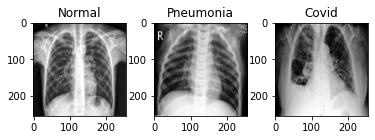

In [23]:
fig, axs = plt.subplots(1, 3)
plt.subplots_adjust(top=1.5,wspace=0.3)

for i, condition_num in enumerate([("Normal", 1), ("Pneumonia", 0), ("Covid", 2)]):
    condition, num = condition_num
    ax = axs[i]
    img_path = os.path.abspath(f"/home/david/phd/VL_MachLearn/Uebung/Covid19-dataset/train/{condition}/{num}.png")
    img = mpimg.imread(img_path)
    ax.imshow(img, cmap=plt.get_cmap('gray'))
    ax.set_title(f"{condition}")
plt.show()

### Creating the model

The images are scaled to a size of 256x256 pixels and will have one color-channel(greyscale). Our first layer will therefor be an InputLayer with an input_shape of (256,256,1). Our next layers for convolutional operations are supposed to be:
- a Conv2D-layer with 3 filters, a 3x3 filter-size, a stride of 1 and a relu-activation-function
- a MaxPooling2D-layer with a pool-size and a stride of 3x3
- a Conv2D-layer with 3 filters, a 3x3 filter-size, a stride of 1 and a relu-activation-function
- a MaxPooling2D-layer with a pool-size and a stride of 3x3
- a Flatten-layer to switch to a regular fully-connected network

The fully-connected part should have:
- a Dense-layer with 50 neurons and a relu-activation
- a Dense-layer with 20 neurons and a relu-activation
- a Dense-layer with an appropiate amount of neurons and a suitable activation-function for out classification-problem

Print a summary of the model

In [24]:
model = Sequential(name="Conv_Net")
model.add(layers.InputLayer(input_shape=(256, 256, 1)))
model.add(layers.Conv2D(filters=3, kernel_size=(3, 3), strides=1, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(3,3)))
model.add(layers.Conv2D(filters=3, kernel_size=(3, 3), strides=1, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(3,3)))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(3, activation="softmax"))
model.summary()

Model: "Conv_Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 3)       30        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 84, 84, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 82, 82, 3)         84        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                109400    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                102

Compile the model with the Adam-optimizer with a learning_rate of 0.0005, CategoricalCrossentropy-loss and keep track of the CategoricalAccuracy

In [25]:
my_optimizer = Adam(learning_rate=0.0005)
my_loss = CategoricalCrossentropy()
my_metrics = [CategoricalAccuracy(name='Accuracy')]

model.compile(
    loss = my_loss,
    optimizer = my_optimizer,
    metrics = my_metrics
    )


### Training the model

Start the training! It should last for 40 epochs. As you supply the training_iterator as training data, you don't have to specify the output-data. Also the batch_size is determined by the iterator and shuffling the data is not possible. We won't give any validation data. If you want turn the verbosity to 0 to supress the information about the proceeding of the training. Make sure to save the history-object to a variable.

In [26]:
history = model.fit(
                    training_iterator,
                    epochs=40,
                    verbose=1)

Epoch 1/40


2022-07-25 09:21:30.619648: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 28321488 exceeds 10% of free system memory.
2022-07-25 09:21:30.631767: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 28321488 exceeds 10% of free system memory.
2022-07-25 09:21:30.645621: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25548336 exceeds 10% of free system memory.


 2/32 [>.............................] - ETA: 4s - loss: 0.6162 - Accuracy: 0.9062 

2022-07-25 09:21:31.187717: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 28321488 exceeds 10% of free system memory.
2022-07-25 09:21:31.188552: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 28321488 exceeds 10% of free system memory.


32/32 [==============================] - 8s 204ms/step - loss: 1.7662 - Accuracy: 0.4222
Epoch 2/40
32/32 [==============================] - 4s 131ms/step - loss: 1.0624 - Accuracy: 0.5011
Epoch 3/40
32/32 [==============================] - 5s 143ms/step - loss: 1.0105 - Accuracy: 0.5881
Epoch 4/40
32/32 [==============================] - 4s 131ms/step - loss: 0.9749 - Accuracy: 0.5151
Epoch 5/40
32/32 [==============================] - 5s 145ms/step - loss: 1.0366 - Accuracy: 0.4819
Epoch 6/40
32/32 [==============================] - 5s 137ms/step - loss: 0.7966 - Accuracy: 0.7437
Epoch 7/40
32/32 [==============================] - 5s 159ms/step - loss: 0.8102 - Accuracy: 0.7197
Epoch 8/40
32/32 [==============================] - 4s 121ms/step - loss: 0.7124 - Accuracy: 0.7439
Epoch 9/40
32/32 [==============================] - 4s 122ms/step - loss: 0.6562 - Accuracy: 0.7985
Epoch 10/40
32/32 [==============================] - 4s 118ms/step - loss: 0.6769 - Accuracy: 0.7253
Epoch 11/4

### Evaluating the model

Plot the loss and the accuarcy during the training. How is the convergence?

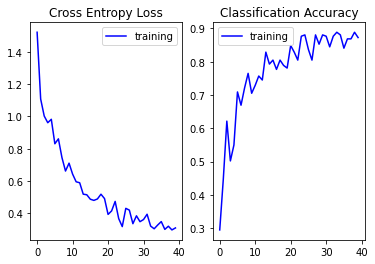

In [39]:
plt.subplot(1, 2, 1)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='training')

plt.legend()
plt.subplot(1, 2, 2)
plt.title('Classification Accuracy')
plt.plot(history.history['Accuracy'], color='blue', label='training')

plt.legend()

plt.show()












Figure out the loss and the accuracy for the test-set with your trained model

In [44]:
predictions = model.predict(test_iterator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_iterator.classes
class_labels = list(test_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

              precision    recall  f1-score   support

       Covid       1.00      0.81      0.89        26
      Normal       0.64      0.70      0.67        20
   Pneumonia       0.70      0.80      0.74        20

    accuracy                           0.77        66
   macro avg       0.78      0.77      0.77        66
weighted avg       0.80      0.77      0.78        66



Finally plot the confusion-matrix for the predictions.

Hint 1: You can get the true classes of your test_iterator by accessing test_iterator.classes

Hint 2: Which number belongs to which class is saved in test_iterator.class_indices

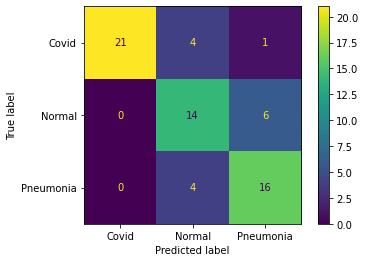

In [45]:
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.show()

That's it from our side. We hope you could get some insight into Machine Learing methods and could pick up some Python!